In [1]:
import gc
import warnings
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from importlib import reload
from textwrap import wrap
from pandas import Timestamp
from icedef import statoil_arcticnet_data as sd
from icedef import test_case, plot, simulator
map_ = plot.get_map()

In [2]:
plt.rcParams['figure.figsize'] = (6, 6)

SMALL_SIZE = 10
MEDIUM_SIZE = 12
LARGE_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

In [3]:
def calc_mean_error(lats_lons, ref_lats_lons):
    
    # lats_lons and ref_lats_lons must be a list of xarray DataArrays with time as a dimension
    
    lats, lons = lats_lons
    ref_lats, ref_lons = ref_lats_lons
    
    n = len(ref_lats.values)
    
    errs = np.zeros(n)
    
    for i in range(n):
        ref_lat = ref_lats.values[i]
        ref_lon = ref_lons.values[i]
        time = ref_lats.time.values[i]
        lat = float(lats.interp(time=time, assume_sorted=True).values)
        lon = float(lons.interp(time=time, assume_sorted=True).values)
        errs[i] = np.sqrt((ref_lon - lon)**2 + (ref_lat - lat)**2)
    
    return np.mean(errs)

In [4]:
def plot_metocean_and_drift_track(field, velocity_field, lon_bounds, lat_bounds, time_bounds, tc, title='',
                                  filename=None):
    
    xs = field.data.longitude.values
    ys = field.data.latitude.values
    ts = field.data.time.values
    uos = velocity_field.eastward_velocities
    vos = velocity_field.northward_velocities

    xi = lon_bounds[0]
    xf = lon_bounds[1]
    yi = lat_bounds[0]
    yf = lat_bounds[1]
    ti = time_bounds[0]
    tf = time_bounds[1]
    xi_index = np.argmin(abs(xs - xi))
    xf_index = np.argmin(abs(xs - xf))
    yi_index = np.argmin(abs(ys - yi))
    yf_index = np.argmin(abs(ys - yf))
    ti_index = np.argmin(abs(ts - ti))
    tf_index = np.argmin(abs(ts - tf))
    
    dx_index = xf_index - xi_index
    dy_index = yf_index - yi_index
    
    if dx_index < 4:
        midx_index = int(np.mean([xi_index, xf_index]))
        xi_index = midx_index - 2
        xf_index = midx_index + 2
    
    if dy_index < 4:
        midy_index = int(np.mean([yi_index, yf_index]))
        yi_index = midy_index - 2
        yf_index = midy_index + 2   
        
    dx_index = xf_index - xi_index
    dy_index = yf_index - yi_index
        
    if dx_index != dy_index:
                
        max_index_range = max([xf_index - xi_index, yf_index - yi_index])
        xf_index = xi_index + max_index_range
        yf_index = yi_index + max_index_range

    xs = field.data.longitude.values[xi_index : xf_index + 1]
    ys = field.data.latitude.values[yi_index : yf_index + 1]
    ts = field.data.time.values[ti_index : tf_index + 1]
    uos = velocity_field.eastward_velocities.values[ti_index : tf_index + 1, yi_index : yf_index + 1, xi_index : xf_index + 1]
    vos = velocity_field.northward_velocities[ti_index : tf_index + 1, yi_index : yf_index + 1, xi_index : xf_index + 1]
    uos = np.mean(uos, axis=0)
    vos = np.mean(vos, axis=0)
    
    map_kwargs = plot.get_map_kwargs(ys[0], xs[0], ys[-1], xs[-1])
    map_ = plot.get_map(**map_kwargs)
    
    parallels = map_.drawparallels(np.arange(ys[0], ys[-1] + np.mean(np.diff(ys)), np.mean(np.diff(ys))),labels=[1,0,0,1])
    meridians = map_.drawmeridians(np.arange(xs[0], xs[-1] + np.mean(np.diff(xs)), np.mean(np.diff(xs))),labels=[1,0,0,1])
    for meridian in meridians:

        try:
            meridians[meridian][1][0].set_rotation(90)

        except IndexError:
            pass
    
    xs_, ys_ = map_(xs, ys)
    xs_1 = np.append(xs_, xs_[-1] + np.mean(np.diff(xs_))) - np.mean(np.diff(xs_)) / 2
    ys_1 = np.append(ys_, ys_[-1] + np.mean(np.diff(ys_))) - np.mean(np.diff(ys_)) / 2
    xxs, yys = np.meshgrid(xs_1, ys_1)
    #map_.imshow(np.sqrt(uos**2 + vos**2), origin='lower', interpolation='bicubic')
    map_.pcolor(xxs, yys, np.sqrt(uos**2 + vos**2))
    map_.quiver(xs_, ys_, uos, vos, units='xy', angles='xy')
    cbar = plt.colorbar()
    cbar.ax.get_yaxis().labelpad = 20
    cbar.ax.set_ylabel('Speed (m/s)', rotation=270)
    berg_xs = tc.ref_lons.values
    berg_ys = tc.ref_lats.values
    berg_xs_, berg_ys_ = map_(berg_xs, berg_ys)
    map_.scatter(berg_xs_, berg_ys_, color='r')
    plt.title('\n'.join(wrap(title)))
    
    if filename:
        fig = plt.gcf()
        fig.savefig(filename, bbox_inches='tight')

In [5]:
def plot_cone(data, labels):
    
    ts = data['reference'].time.values
    lats = data['reference'].latitude.values
    lons = data['reference'].longitude.values
    sim_lats = np.empty((len(ts), len(labels)))
    sim_lons = np.empty((len(ts), len(labels)))

    for i in range(len(ts)):
        t = ts[i]
        for j, label in enumerate(labels):
            dat = data[label]
            sim_lats[i, j] = float(dat['latitude'].interp(time=t, assume_sorted=True).values)
            sim_lons[i, j] = float(dat['longitude'].interp(time=t, assume_sorted=True).values)

    fig = plt.figure(figsize=(16, 12))

    with warnings.catch_warnings():

        warnings.simplefilter("ignore")

        mean_lats = np.mean(sim_lats, axis=1)
        mean_lons = np.mean(sim_lons, axis=1) 

        std1_lats = np.std(sim_lats, axis=1)
        std1_lons = np.std(sim_lons, axis=1)

        min1_lats = mean_lats - std1_lats
        min1_lons = mean_lons - std1_lons
        max1_lats = mean_lats + std1_lats
        max1_lons = mean_lons + std1_lons

        min2_lats = mean_lats - 2 * std1_lats
        min2_lons = mean_lons - 2 * std1_lons
        max2_lats = mean_lats + 2 * std1_lats
        max2_lons = mean_lons + 2 * std1_lons

        min3_lats = mean_lats - 3 * std1_lats
        min3_lons = mean_lons - 3 * std1_lons
        max3_lats = mean_lats + 3 * std1_lats
        max3_lons = mean_lons + 3 * std1_lons

        plt.plot(mean_lons, mean_lats, label='mean')

        polygon1_xys = np.column_stack((np.vstack((min1_lons, max1_lons[::-1])).ravel(), 
                                        np.vstack((min1_lats, max1_lats[::-1])).ravel()))
        polygon2_xys = np.column_stack((np.vstack((min2_lons, max2_lons[::-1])).ravel(), 
                                        np.vstack((min2_lats, max2_lats[::-1])).ravel()))
        polygon3_xys = np.column_stack((np.vstack((min3_lons, max3_lons[::-1])).ravel(), 
                                        np.vstack((min3_lats, max3_lats[::-1])).ravel()))

        polygon1 = Polygon(polygon1_xys, fill=True, alpha=0.2, label='σ1')
        polygon2 = Polygon(polygon2_xys, fill=True, alpha=0.2, label='σ2')
        polygon3 = Polygon(polygon3_xys, fill=True, alpha=0.2, label='σ3')

        ax = plt.gca()
        ax.add_patch(polygon1)
        ax.add_patch(polygon2)
        ax.add_patch(polygon3)

        ax.scatter(lons, lats, color='k')


        # ADDING TIME LINES
        for dt in np.arange(6, 24, 6):
            for min_lons, max_lons, min_lats, max_lats in zip([min1_lons, min2_lons, min3_lons], 
                                                                     [max1_lons, max2_lons, max3_lons],
                                                                     [min1_lats, min2_lats, min3_lats], 
                                                                     [max1_lats, max2_lats, max3_lats]):

                xr_min_lats = xr.DataArray(data=min_lats, coords=[ts], dims=['time'])
                xr_min_lons = xr.DataArray(data=min_lons, coords=[ts], dims=['time'])
                xr_max_lats = xr.DataArray(data=max_lats, coords=[ts], dims=['time'])
                xr_max_lons = xr.DataArray(data=max_lons, coords=[ts], dims=['time'])
                t = ts[0] + np.timedelta64(int(dt), 'h')
                xr_min_lat = float(xr_min_lats.interp(time=t, assume_sorted=True).values)
                xr_min_lon = float(xr_min_lons.interp(time=t, assume_sorted=True).values)
                xr_max_lat = float(xr_max_lats.interp(time=t, assume_sorted=True).values)
                xr_max_lon = float(xr_max_lons.interp(time=t, assume_sorted=True).values)
                plt.plot([xr_min_lon, xr_max_lon], [xr_min_lat, xr_max_lat], color='k', zorder=10)
            plt.annotate(s=f'{dt} hours in', xy=[xr_max_lon, xr_max_lat])

        #


        # ax.set_ylim(51.4, 51.65)
        ax.set_aspect('equal', adjustable='box')   

        plt.legend()

In [6]:
def plot_cone2(data, labels, title='', filename=None):
    
    ts = data['reference'].time.values
    lats = data['reference'].latitude.values
    lons = data['reference'].longitude.values
    sim_lats = np.empty((len(ts), len(labels)))
    sim_lons = np.empty((len(ts), len(labels)))

    for i in range(len(ts)):
        t = ts[i]
        for j, label in enumerate(labels):
            dat = data[label]
            sim_lats[i, j] = float(dat['latitude'].interp(time=t, assume_sorted=True).values)
            sim_lons[i, j] = float(dat['longitude'].interp(time=t, assume_sorted=True).values)

    with warnings.catch_warnings():

        warnings.simplefilter("ignore")

        mean_lats = np.mean(sim_lats, axis=1)
        mean_lons = np.mean(sim_lons, axis=1) 
        
        plt.plot(mean_lons, mean_lats, label='mean')

        std_lats = np.std(sim_lats, axis=1)
        std_lons = np.std(sim_lons, axis=1)
        
        ax = plt.gca()
        
        for j in range(1, 4):
        
            lats_high = []
            lons_high = []
            lats_low = []
            lons_low = []
            
            for i in range(1, len(ts)):

                angle = np.arctan2((mean_lats[i] - mean_lats[i-1]),  (mean_lons[i] - mean_lons[i-1]))
                sigma = j * np.sqrt(std_lats[i]**2 + std_lons[i]**2)
                
                if 90 <= np.rad2deg(angle) <= 180 or -180 <= np.rad2deg(angle) <= -90:
                                    
                    y1 = mean_lats[i] + sigma * np.cos(angle)
                    y2 = mean_lats[i] - sigma * np.cos(angle)
                    x1 = mean_lons[i] - sigma * np.sin(angle)
                    x2 = mean_lons[i] + sigma * np.sin(angle)
                    
                else:
                    
                    y1 = mean_lats[i] + sigma * np.sin(angle)
                    y2 = mean_lats[i] - sigma * np.sin(angle)
                    x1 = mean_lons[i] - sigma * np.cos(angle)
                    x2 = mean_lons[i] + sigma * np.cos(angle)
                    

                if y1 > y2:

                    lats_high.append(y1)
                    lons_high.append(x1)
                    lats_low.append(y2)
                    lons_low.append(x2)

                else:

                    lats_high.append(y2)
                    lons_high.append(x2)
                    lats_low.append(y1)
                    lons_low.append(x1)

            lats_high = np.array(lats_high)
            lons_high = np.array(lons_high)
            lats_low = np.array(lats_low)
            lons_low = np.array(lons_low)

            lons_ = np.append(np.vstack((lons_low, lons_high[::-1])).ravel(), mean_lons[0])
            lats_ = np.append(np.vstack((lats_low, lats_high[::-1])).ravel(), mean_lats[0])
            
            polygon_xys = np.column_stack((lons_, lats_))
            polygon = Polygon(polygon_xys, fill=True, alpha=0.2, label=fr'$\sigma_{j}$')
            ax.add_patch(polygon)

    ax.scatter(lons, lats, color='k')
    ax.set_aspect('equal', adjustable='box')   
    plt.legend()
    plt.title('\n'.join(wrap(title)))
    plt.xticks([])
    plt.yticks([])
    
    if filename:
        fig = plt.gcf()
        fig.savefig(filename, bbox_inches='tight')


In [7]:
def main(tc, sim, n=2):
    
    title = 'Observed Iceberg Track'
    lats, lons = tc.ref_lats.values, tc.ref_lons.values
    s = 'Start'
    xy = lons[0], lats[0]
    annotation_args = {'s': s, 'xy': xy}
    map_kwargs = {'pads': 0.02}
    fig, ax = plot.plot_track((lats, lons), sizes=60, title=title, 
                              **{'annotation_args': annotation_args, 'map_kwargs': map_kwargs})
    directory = './plots/'
    filename = title.replace(" ", "_").lower() + '.png'
    fig.savefig(directory+filename, bbox_inches='tight')
    plt.show()
      
    print('Plotting metocean data...')
    
    time_bounds = [tc.ref_times[0], tc.ref_times[-1]]
    
    min_ref_lon = min(tc.ref_lons.values)
    max_ref_lon = max(tc.ref_lons.values)
    diff_ref_lon = abs(max_ref_lon - min_ref_lon)
    
    min_ref_lat = min(tc.ref_lats.values)
    max_ref_lat = max(tc.ref_lats.values)
    diff_ref_lat = abs(max_ref_lat - min_ref_lat)
    
    # For ocean
    
    field = sim.ocean
    velocity_field = field.current
    
    dx_grid = dy_grid = 1/12
    
    plot_scalings = [1]
    
    for plot_scaling in plot_scalings:
    
        lon_bounds = np.array([min_ref_lon - dx_grid * plot_scaling, max_ref_lon + dx_grid * plot_scaling])
        lat_bounds = np.array([min_ref_lat - dy_grid * plot_scaling, max_ref_lat + dy_grid * plot_scaling])

        title = 'Mean Current Velocities Near Iceberg Track'
        directory = './plots/'
        filename = title.replace(" ", "_").lower() + '.png'
        plot_metocean_and_drift_track(field, velocity_field, lon_bounds, lat_bounds, time_bounds, tc, 
                                      title=title, filename=directory+filename)
        plt.show()    
    
    # For atmosphere
    
    field = sim.atmosphere
    velocity_field = field.wind
    
    dx_grid = dy_grid = 1/4
    
    plot_scalings = [1]
    
    for plot_scaling in plot_scalings:
    
        lon_bounds = np.array([min_ref_lon - dx_grid * plot_scaling, max_ref_lon + dx_grid * plot_scaling])
        lat_bounds = np.array([min_ref_lat - dy_grid * plot_scaling, max_ref_lat + dy_grid * plot_scaling])

        title = 'Mean Wind Velocities Near Iceberg Track'
        directory = './plots/'
        filename = title.replace(" ", "_").lower() + '.png'
        plot_metocean_and_drift_track(field, velocity_field, lon_bounds, lat_bounds, time_bounds, tc, 
                                      title=title, filename=directory+filename)
        plt.show() 

    
    print('Optimizing Ca and Cw...')
    
    ref_lats_lons = tc.ref_lats, tc.ref_lons

    Ca, Cw = None, None
    run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
                      'perturb_current': True, 'perturb_wind': True,
                      'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}

    N = n**2

    num_start_times = 1

    err_dict = {'Ca': np.zeros((num_start_times, N)), 'Cw': np.zeros((num_start_times, N)), 
                'err': np.zeros((num_start_times, N))}
    
    Cas = np.linspace(0.1, 4, n)
    Cws = np.linspace(0.1, 4, n)
    Ca_mesh, Cw_mesh = np.meshgrid(Cas, Cws)
    Cas = Ca_mesh.flatten()
    Cws = Cw_mesh.flatten()

    for j in range(num_start_times):

        for i in range(N):                
                
            Ca = Cas[i]
            Cw = Cws[i]
            run_sim_kwargs['Ca'] = Ca
            run_sim_kwargs['Cw'] = Cw
            sim.run_simulation(label=f'{i + (j * N)}', **run_sim_kwargs)
            lats = sim.results.data[f'{i + (j * N)}']['latitude']
            lons = sim.results.data[f'{i + (j * N)}']['longitude']
            lats_lons = lats, lons
            err = calc_mean_error(lats_lons, ref_lats_lons)
            err_dict['Ca'][j][i] = Ca
            err_dict['Cw'][j][i] = Cw
            err_dict['err'][j][i] = err

    labels = [str(i) for i in range(N * num_start_times)] + ['reference']
    sizes = [2] * N * num_start_times + [60]
    markers = ['.'] * (N * num_start_times + 1)
    fig, ax = sim.results.plot(labels, sizes=sizes)
    plt.show()
    
    print('Plotting optimized track...')
    
    labels = []
    for i in range(num_start_times):
        index = np.argmin(err_dict['err'][i][:])
        min_err = err_dict['err'][i][index]
        optimal_Ca = err_dict['Ca'][i][index]
        optimal_Cw = err_dict['Cw'][i][index]
        print('err: {}, Ca: {}, Cw: {}'.format(min_err, optimal_Ca, optimal_Cw))
        labels.append(f'{index + N*i}')
    labels += ['reference']
    sizes = [2] * num_start_times + [60]
    title = 'Simulated and Observed Iceberg Track'
    fig, ax = sim.results.plot(labels, sizes=sizes, **{'title':title, 'labels': ['Simulated', 'Observed']})
    directory = './plots/'
    filename = title.replace(" ", "_").lower() + '.png'
    fig.savefig(directory+filename, bbox_inches='tight')
    plt.show()
    
    labels = [str(i) for i in range(N * num_start_times)]
    for label in labels:
        sim.results.remove_dataset(label)
    
    print('Running ensemble...')

    Ca, Cw = optimal_Ca, optimal_Cw
    run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.2}

    num_start_times = 1

    N = 10
    
    for j in range(num_start_times):

        for i in range(N):

            sim.run_simulation(label=f'{i + (j * N)}', **run_sim_kwargs)


    labels = [str(i) for i in range(N * num_start_times)] + ['reference']
    sizes = [2] * N * num_start_times + [60]
    markers = ['.'] * (N * num_start_times + 1)
    title = 'Simulated and Observed Iceberg Tracks'
    fig, ax = sim.results.plot(labels, sizes=sizes, **{'title':title})
    directory = './plots/'
    filename = title.replace(" ", "_").lower() + '.png'
    fig.savefig(directory+filename, bbox_inches='tight')    
    plt.show()
    
    title = 'Ensemble Cone'
    directory = './plots/'
    filename = title.replace(" ", "_").lower() + '.png'
    plot_cone2(sim.results.data, [str(i) for i in range(N)], title=title, filename=directory+filename)
    plt.show()
    
    return optimal_Ca, optimal_Cw

# Good Berg

##  Day 1

In [8]:
#beacon_id = '20498'
beacon_id = '90679'
df = sd.get_beacon_df(beacon_id=beacon_id)
# note index 809 is where the hourly averaging starts
start_time = df.DataDate_UTC.values[809]
end_time = start_time + np.timedelta64(1, 'D')
tc = test_case.TestCase(beacon_id=beacon_id, start_time=start_time, end_time=end_time)

Day 0
2015-04-24 21:51:42 - 2015-04-25 20:51:58


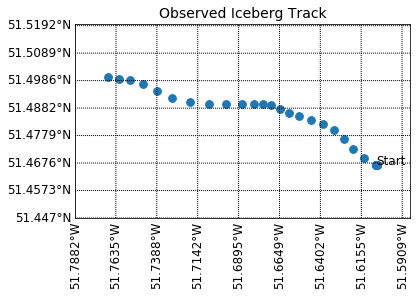

Plotting metocean data...


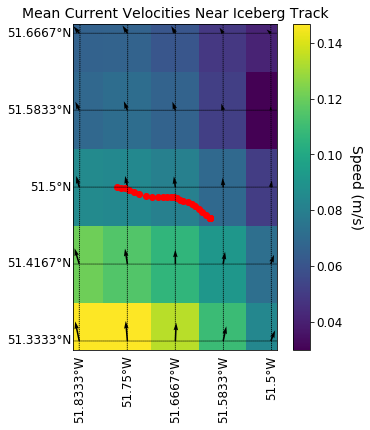

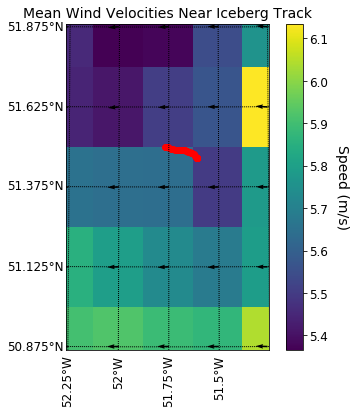

Optimizing Ca and Cw...


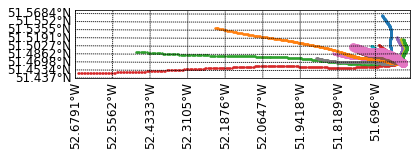

Plotting optimized track...
err: 0.011173501736443282, Ca: 1.4000000000000001, Cw: 1.4000000000000001


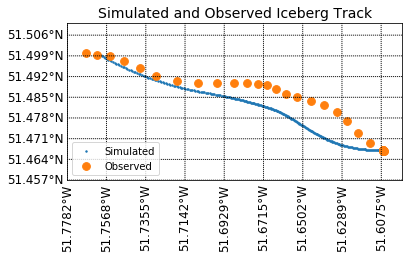

Running ensemble...


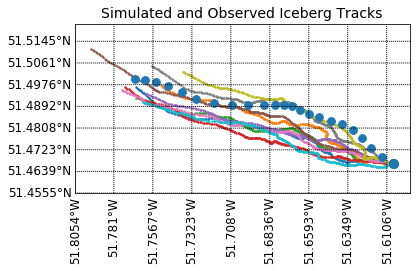

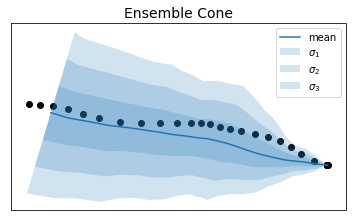

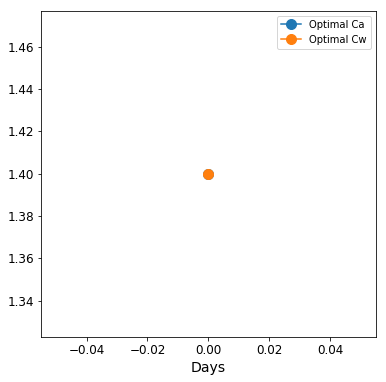

In [9]:
start_day = 0
num_days = 1
days = range(start_day, start_day + num_days)
#days = [7, 8]

optimal_Cas = np.empty(num_days)
optimal_Cws = np.empty(num_days)


for i, day in enumerate(days):
    
    print(f'Day {day}')
    
    start_time = df.DataDate_UTC.values[809] + np.timedelta64(day, 'D')
    end_time = start_time + np.timedelta64(1, 'D')
    tc = test_case.TestCase(beacon_id=beacon_id, start_time=start_time, end_time=end_time)
    
    print(f'{Timestamp(tc.start_time)} - {Timestamp(tc.end_time)}')
    
    sim_args = tc.time_frame, tc.start_location, tc.start_velocity
    sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
    reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
    sim.results.add_from_dict(reference_data_dict, label='reference')
    sim.testcase = tc
    
    optimal_Cas[i], optimal_Cws[i] = main(tc, sim, n=4)
    
    #del sim
    #del tc
    
    gc.collect()

plt.plot(range(len(optimal_Cas)), optimal_Cas, '.-', markersize=20, label='Optimal Ca')
plt.plot(range(len(optimal_Cws)), optimal_Cws, '.-', markersize=20, label='Optimal Cw')
plt.xlabel('Days')
plt.legend()
plt.show()

In [10]:
map_ = plot.get_map()
sim.results.add_map(map_=map_)

for label in list(sim.results.data.keys()):
    sim.results.add_xy_to_existing_dataset(label)

In [11]:
results = sim.results
rd = results.data

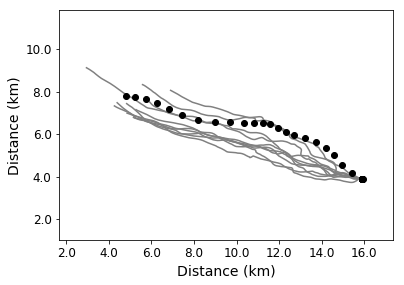

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
ax.margins(x=0.1, y=0.5)
for label in list(rd.keys()):
    if not label == 'reference':
        ax.plot(rd[label]['easting'], rd[label]['northing'], color='grey')

ax.scatter(rd['reference']['easting'], rd['reference']['northing'], color='black', zorder=len(list(rd.keys())))

        
xtick_0 = ax.get_xticks()[0]
xtick_labels = []
for tick in ax.get_xticks(): 
    tick = round((tick - xtick_0), 2)
    xtick_labels.append(str(tick))
ax.set_xticklabels(xtick_labels)
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Distance (km)')

ytick_0 = ax.get_yticks()[0]
ytick_labels = []
for tick in ax.get_yticks(): 
    tick = round((tick - ytick_0), 2)
    ytick_labels.append(str(tick))
ax.set_yticklabels(ytick_labels)

fig.savefig('./plots/test.pdf', bbox_inches='tight')

plt.show()

# Probabilistic Contour Map

In [13]:
x0, y0 = rd['reference']['easting'].values[0], rd['reference']['northing'].values[0]

In [14]:
for label in list(rd.keys()):
    rd[label]['easting'].values -= x0
    rd[label]['northing'].values -= y0

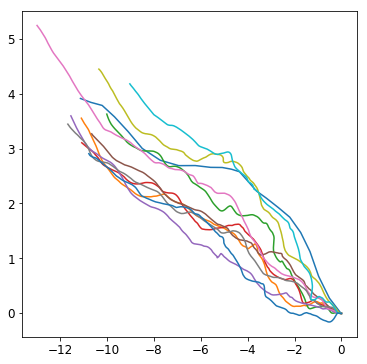

In [15]:
for label in list(rd.keys()):
    plt.plot(rd[label]['easting'], rd[label]['northing'])

In [19]:
labels = list(rd.keys())

x_data = []
y_data = []

for i, label in enumerate(labels):
    if not label == 'reference':
        x_data.append(rd[label]['easting'].values)
        y_data.append(rd[label]['northing'].values)

x_data = np.array(x_data)
y_data = np.array(y_data)

In [82]:
r = 0.5
dx = 0.05
dy = 0.05

X, Y = np.mgrid[-15:2:dx, -2:6:dy]
Z = np.zeros_like(X, dtype='int')

for x, y in zip(x_data, y_data):
    Z_ = np.zeros_like(Z)
    for x_, y_ in zip(x, y):
        Z_[np.sqrt((X+dx/2-x_)**2 + (Y+dy/2-y_)**2) < r] = 1
    Z += Z_
    
# divide by the realizations to come up with a probability
m = len(labels) - 1
Z = Z / m

In [89]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_probabilistic_map(XYZ, xys, ref_xys=None, cbar_step=0.1):
    
    X, Y, Z = XYZ
    x_data, y_data = xys
    ref_x, ref_y  = ref_xys
    
    n_levels = np.arange(0, 1 + cbar_step, cbar_step)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, aspect='equal')
    
    if ref_xys:
        plt.scatter(ref_x, ref_y, color='black', zorder=1000, label='observed')
    
    plt.contourf(X, Y, Z, n_levels, alpha=0.7)

    plt.plot(x_data.T, y_data.T, 'k-',  alpha=0.2, linewidth=1.5)
    plt.plot(np.mean(x_data, 0), np.mean(y_data, 0), 'k-', linewidth=2, label='mean')
      
    plt.legend()

    plt.xlabel('Position (km)')
    plt.ylabel('Position (km)')
    plt.title('Probability contour map of location of iceberg')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)
    
    plt.show()

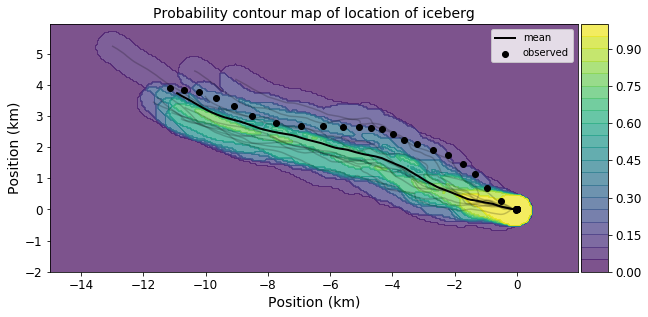

In [91]:
ref_x = rd['reference']['easting'].values
ref_y = rd['reference']['northing'].values
plot_probabilistic_map((X, Y, Z), (x_data, y_data), (ref_x, ref_y), 0.05)

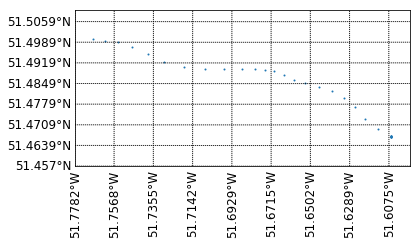

In [95]:
fig, ax = sim.results.plot(['reference'])

In [216]:
field = sim.ocean.data
velocity_field = sim.ocean.current

lons = field.longitude.values
lats = field.latitude.values
x_indices = np.where((lons >= -52) & (lons <= -51))[0]
x_index_0, x_index_n = x_indices[0], x_indices[-1]
y_indices = np.where((lats >= 51) & (lats <= 52))[0]
y_index_0, y_index_n = y_indices[0], y_indices[-1]
lons = lons[x_index_0 : x_index_n + 1]
lats = lats[y_index_0 : y_index_n + 1]
us = velocity_field.eastward_velocities.values[:, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
us = np.mean(us, axis=0)
vs = velocity_field.northward_velocities.values[:, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
vs = np.mean(vs, axis=0)

xs_, ys_ = map_(lons, lats) 

xs = (xs_ / 1000) - x0
ys = (ys_ / 1000) - y0
xxs, yys = np.meshgrid(xs, ys)

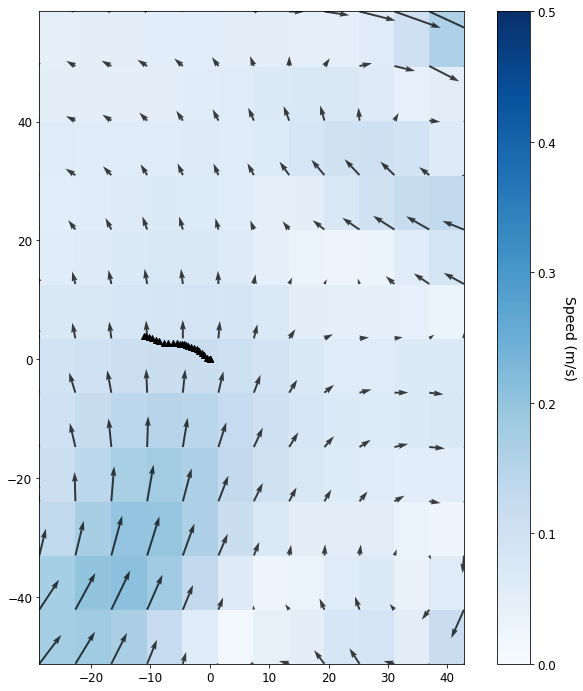

In [217]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, aspect='equal')

plt.pcolor(xxs, yys, np.sqrt(us**2 + vs**2), cmap='Blues', vmin=0, vmax=0.5)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('Speed (m/s)', rotation=270)

plt.quiver(xxs, yys, us, vs, units='xy', angles='xy', alpha=0.75)
plt.scatter(ref_x, ref_y, color='black', marker='^')

In [190]:
field = sim.atmosphere.data
velocity_field = sim.atmosphere.wind

lons = field.longitude.values
lats = field.latitude.values
x_indices = np.where((lons >= -52) & (lons <= -51))[0]
x_index_0, x_index_n = x_indices[0], x_indices[-1]
y_indices = np.where((lats >= 51) & (lats <= 52))[0]
y_index_0, y_index_n = y_indices[0], y_indices[-1] + 1
lons = lons[x_index_0 : x_index_n + 1]
lats = lats[y_index_0 : y_index_n + 1]
us = velocity_field.eastward_velocities.values[:, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
us = np.mean(us, axis=0)
vs = velocity_field.northward_velocities.values[:, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
vs = np.mean(vs, axis=0)

xs_, ys_ = map_(lons, lats) 

xs = (xs_ / 1000) - x0
ys = (ys_ / 1000) - y0
xxs, yys = np.meshgrid(xs, ys)

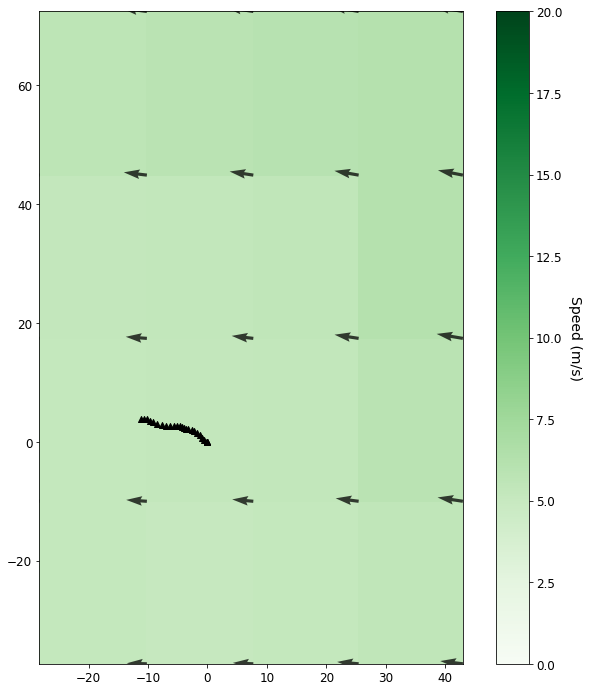

In [197]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, aspect='equal')

plt.pcolor(xxs, yys, np.sqrt(us**2 + vs**2), cmap='Greens', vmin=0, vmax=20)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('Speed (m/s)', rotation=270)

plt.quiver(xxs, yys, us, vs, units='xy', angles='xy', alpha=0.75)
plt.scatter(ref_x, ref_y, color='black', marker='^')

In [198]:
from icedef import metocean

In [202]:
atm = metocean.Atmosphere((np.datetime64('2015-04-01'), np.datetime64('2015-05-01')))

Attempting to download http://icedef.munroelab.ca/data/NARR/atm/daily/20150401.nc... done.
Attempting to download http://icedef.munroelab.ca/data/NARR/atm/daily/20150402.nc... done.
Attempting to download http://icedef.munroelab.ca/data/NARR/atm/daily/20150403.nc... done.


In [203]:
field = atm.data
velocity_field = atm.wind

lons = field.longitude.values
lats = field.latitude.values
x_indices = np.where((lons >= -52) & (lons <= -51))[0]
x_index_0, x_index_n = x_indices[0], x_indices[-1]
y_indices = np.where((lats >= 51) & (lats <= 52))[0]
y_index_0, y_index_n = y_indices[0], y_indices[-1] + 1
lons = lons[x_index_0 : x_index_n + 1]
lats = lats[y_index_0 : y_index_n + 1]
us = velocity_field.eastward_velocities.values[:, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
vs = velocity_field.northward_velocities.values[:, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
ws = np.sqrt(us**2 + vs**2)

(array([ 289., 1354., 1404., 1412.,  761.,  592.,  228.,  156.,  151.,
          53.]),
 array([ 0.05461944,  1.69748265,  3.34034587,  4.98320908,  6.62607229,
         8.26893551,  9.91179872, 11.55466193, 13.19752515, 14.84038836,
        16.48325157]),
 <a list of 10 Patch objects>)

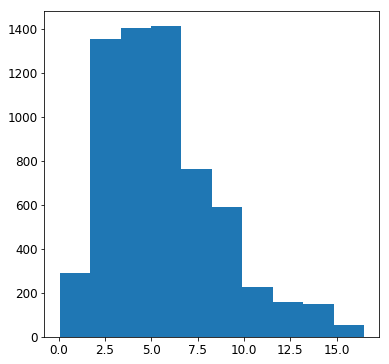

In [210]:
plt.hist(ws.flatten())

In [211]:
ocean = metocean.Ocean((np.datetime64('2015-04-01'), np.datetime64('2015-05-01')))

In [213]:
field = ocean.data
velocity_field = ocean.current

lons = field.longitude.values
lats = field.latitude.values
x_indices = np.where((lons >= -52) & (lons <= -51))[0]
x_index_0, x_index_n = x_indices[0], x_indices[-1]
y_indices = np.where((lats >= 51) & (lats <= 52))[0]
y_index_0, y_index_n = y_indices[0], y_indices[-1]
lons = lons[x_index_0 : x_index_n + 1]
lats = lats[y_index_0 : y_index_n + 1]
us = velocity_field.eastward_velocities.values[:, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
vs = velocity_field.northward_velocities.values[:, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
ws = np.sqrt(us**2 + vs**2)

(array([2.6092e+04, 4.5342e+04, 3.0645e+04, 1.6076e+04, 7.2110e+03,
        3.0830e+03, 1.1510e+03, 1.6100e+02, 2.1000e+01, 1.0000e+01]),
 array([0.        , 0.06039199, 0.12078398, 0.18117598, 0.24156797,
        0.30195996, 0.36235195, 0.42274395, 0.48313594, 0.54352793,
        0.60391992]),
 <a list of 10 Patch objects>)

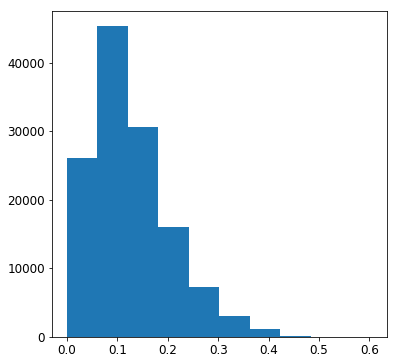

In [214]:
plt.hist(ws.flatten())

Text(0,0.5,'Standard Deviation')

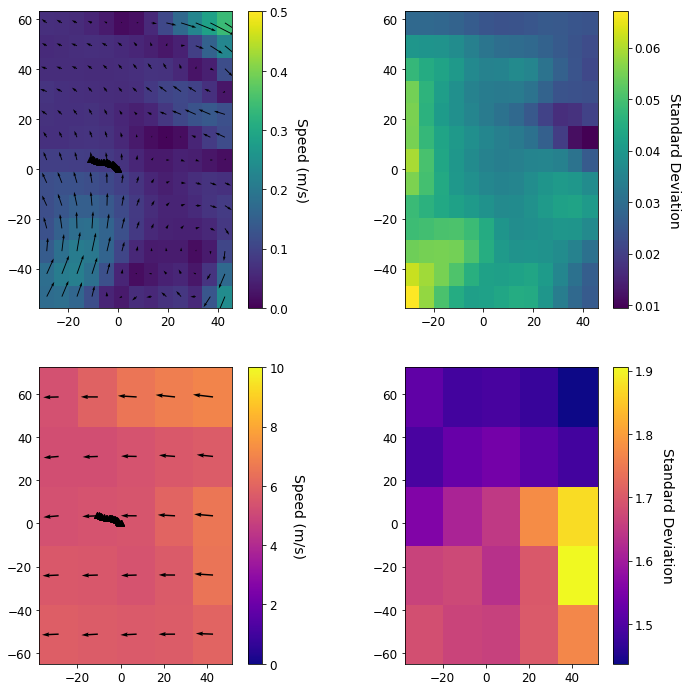

In [282]:
llcrnrlon = -52
llcrnrlat = 51
urcrnrlon = -51
urcrnrlat = 52

# Subplot 1 - Ocean

field = sim.ocean.data
velocity_field = sim.ocean.current

lons = field.longitude.values
lats = field.latitude.values
times = field.time.values
x_indices = np.where((lons >= llcrnrlon) & (lons <= urcrnrlon))[0]
x_index_0, x_index_n = x_indices[0], x_indices[-1]
y_indices = np.where((lats >= llcrnrlat) & (lats <= urcrnrlat))[0]
y_index_0, y_index_n = y_indices[0], y_indices[-1]
t_indices = np.where((times >= tc.start_time) & (times <= tc.end_time))[0]
t_index_0, t_index_n = t_indices[0], t_indices[-1]
lons = lons[x_index_0 : x_index_n + 1]
lats = lats[y_index_0 : y_index_n + 1]
times = times[t_index_0 : t_index_n + 1]
us = velocity_field.eastward_velocities.values[t_index_0 : t_index_n + 1, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
mean_us = np.mean(us, axis=0)
vs = velocity_field.northward_velocities.values[t_index_0 : t_index_n + 1, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
mean_vs = np.mean(vs, axis=0)

xs_, ys_ = map_(lons, lats)
xs = (xs_ / 1000) - x0
ys = (ys_ / 1000) - y0

xs_1 = np.append(xs, xs[-1] + np.mean(np.diff(xs))) - np.mean(np.diff(xs)) / 2
ys_1 = np.append(ys, ys[-1] + np.mean(np.diff(ys))) - np.mean(np.diff(ys)) / 2
xxs, yys = np.meshgrid(xs_1, ys_1)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(221, aspect='equal')

plt.pcolor(xxs, yys, np.sqrt(mean_us**2 + mean_vs**2), cmap='viridis', vmin=0, vmax=0.5)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('Speed (m/s)', rotation=270)

plt.quiver(xs, ys, mean_us, mean_vs, units='xy', angles='xy')
plt.scatter(ref_x, ref_y, color='black', marker='^')


ax = fig.add_subplot(222, aspect='equal')
std_us = np.std(us, axis=0)
std_vs = np.std(us, axis=0)
plt.pcolor(xxs, yys, np.sqrt(std_us**2 + std_vs**2), cmap='viridis')
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('Standard Deviation', rotation=270)


# Subplot 2 - Wind

field = sim.atmosphere.data
velocity_field = sim.atmosphere.wind

lons = field.longitude.values
lats = field.latitude.values - 0.125
times = field.time.values
x_indices = np.where((lons >= llcrnrlon) & (lons <= urcrnrlon))[0]
x_index_0, x_index_n = x_indices[0], x_indices[-1]
y_indices = np.where((lats >= llcrnrlat) & (lats <= urcrnrlat))[0]
y_index_0, y_index_n = y_indices[0], y_indices[-1]
t_indices = np.where((times >= tc.start_time) & (times <= tc.end_time))[0]
t_index_0, t_index_n = t_indices[0], t_indices[-1]
lons = lons[x_index_0 : x_index_n + 1]
lats = lats[y_index_0 : y_index_n + 1]
times = times[t_index_0 : t_index_n + 1]
us = velocity_field.eastward_velocities.values[t_index_0 : t_index_n + 1, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
mean_us = np.mean(us, axis=0)
vs = velocity_field.northward_velocities.values[t_index_0 : t_index_n + 1, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
mean_vs = np.mean(vs, axis=0)

xs_, ys_ = map_(lons, lats)
xs = (xs_ / 1000) - x0
ys = (ys_ / 1000) - y0

xs_1 = np.append(xs, xs[-1] + np.mean(np.diff(xs))) - np.mean(np.diff(xs)) / 2
ys_1 = np.append(ys, ys[-1] + np.mean(np.diff(ys))) - np.mean(np.diff(ys)) / 2
xxs, yys = np.meshgrid(xs_1, ys_1)

ax = fig.add_subplot(223, aspect='equal')

plt.pcolor(xxs, yys, np.sqrt(mean_us**2 + mean_vs**2), cmap='plasma', vmin=0, vmax=10)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('Speed (m/s)', rotation=270)

plt.quiver(xs, ys, mean_us, mean_vs, units='xy', angles='xy', scale=0.75)
plt.scatter(ref_x, ref_y, color='black', marker='^')

ax = fig.add_subplot(224, aspect='equal')
std_us = np.std(us, axis=0)
std_vs = np.std(us, axis=0)
plt.pcolor(xxs, yys, np.sqrt(std_us**2 + std_vs**2), cmap='plasma')
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('Standard Deviation', rotation=270)

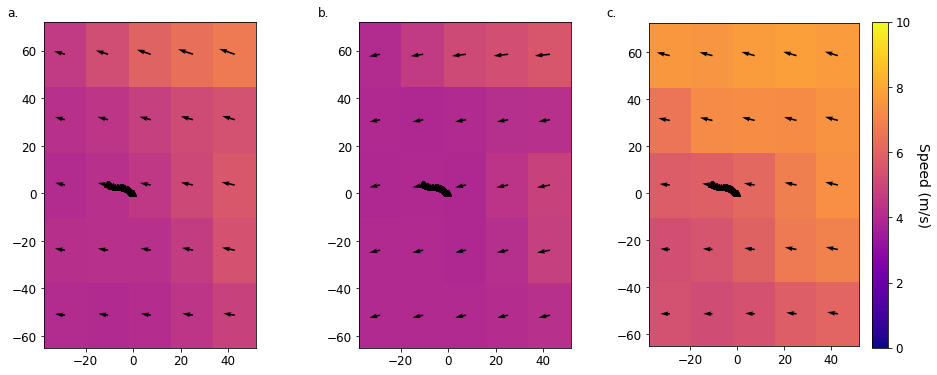

In [330]:
cmap = 'plasma'
vmin = 0
vmax = 10

llcrnrlon = -52
llcrnrlat = 51
urcrnrlon = -51
urcrnrlat = 52

# field = sim.ocean.data
# velocity_field = sim.ocean.current

field = sim.atmosphere.data
velocity_field = sim.atmosphere.wind

lons = field.longitude.values
lats = field.latitude.values - 0.125
times = field.time.values
x_indices = np.where((lons >= llcrnrlon) & (lons <= urcrnrlon))[0]
x_index_0, x_index_n = x_indices[0], x_indices[-1]
y_indices = np.where((lats >= llcrnrlat) & (lats <= urcrnrlat))[0]
y_index_0, y_index_n = y_indices[0], y_indices[-1]
t_indices = np.where((times >= tc.start_time) & (times <= tc.end_time))[0]
t_index_0, t_index_n = t_indices[0], t_indices[-1]
lons = lons[x_index_0 : x_index_n + 1]
lats = lats[y_index_0 : y_index_n + 1]
times = times[t_index_0 : t_index_n + 1]


us_0 = velocity_field.eastward_velocities.values[0, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
us_12 = velocity_field.eastward_velocities.values[3, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
us_24 = velocity_field.eastward_velocities.values[-1, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]

vs_0 = velocity_field.northward_velocities.values[0, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
vs_12 = velocity_field.northward_velocities.values[3, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
vs_24 = velocity_field.northward_velocities.values[-1, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]

xs_, ys_ = map_(lons, lats)
xs = (xs_ / 1000) - x0
ys = (ys_ / 1000) - y0

xs_1 = np.append(xs, xs[-1] + np.mean(np.diff(xs))) - np.mean(np.diff(xs)) / 2
ys_1 = np.append(ys, ys[-1] + np.mean(np.diff(ys))) - np.mean(np.diff(ys)) / 2
xxs, yys = np.meshgrid(xs_1, ys_1)

fig = plt.figure(figsize=(16, 6))
fig.tight_layout()

ax1 = fig.add_subplot(131, aspect='equal')
plt.pcolor(xxs, yys, np.sqrt(us_0**2 + vs_0**2), cmap=cmap, vmin=vmin, vmax=vmax)
plt.quiver(xs, ys, us_0, vs_0, units='xy', angles='xy')
plt.scatter(ref_x, ref_y, color='black', marker='^')
plt.figtext(0.12, 0.9,'a.',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)


ax2 = fig.add_subplot(132, aspect='equal')
plt.pcolor(xxs, yys, np.sqrt(us_12**2 + vs_12**2), cmap=cmap, vmin=vmin, vmax=vmax)
plt.quiver(xs, ys, us_12, vs_12, units='xy', angles='xy')
plt.scatter(ref_x, ref_y, color='black', marker='^')
plt.figtext(0.39, 0.9,'b.',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)

ax3 = fig.add_subplot(133, aspect='equal')
plt.pcolor(xxs, yys, np.sqrt(us_24**2 + vs_24**2), cmap=cmap, vmin=vmin, vmax=vmax)

cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('Speed (m/s)', rotation=270)

plt.quiver(xs, ys, us_24, vs_24, units='xy', angles='xy')
plt.scatter(ref_x, ref_y, color='black', marker='^')
plt.figtext(0.64, 0.9,'c.',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)

plt.show()